In [2]:
import pandas as pd
import numpy as np

# Load your dataset (adjust the path to your CSV file)
df = pd.read_csv('vehicles.csv')

# View the first few rows
df.head()


,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [3]:
# Drop rows with missing essential values
df.dropna(subset=['price', 'year', 'odometer'], inplace=True)

# Remove rows with unrealistic price or odometer
df = df[df['price'] > 100]
df = df[(df['year'] >= 1990) & (df['year'] <= 2025)]
df = df[(df['odometer'] > 0) & (df['odometer'] < 500000)]

df.shape  # Check remaining number of rows and columns

(373445, 26)

In [4]:
# Select relevant columns (adjust based on what's in your dataset)
keep_columns = ['price', 'year', 'odometer', 'condition', 'cylinders', 'fuel', 'transmission', 'type']
df = df[[col for col in keep_columns if col in df.columns]]

df.head()

,price,year,odometer,condition,cylinders,fuel,transmission,type
27,33590,2014.0,57923.0,good,8 cylinders,gas,other,pickup
28,22590,2010.0,71229.0,good,8 cylinders,gas,other,pickup
29,39590,2020.0,19160.0,good,8 cylinders,gas,other,pickup
30,30990,2017.0,41124.0,good,8 cylinders,gas,other,pickup
31,15000,2013.0,128000.0,excellent,6 cylinders,gas,automatic,truck


In [5]:
# Map condition text to numeric
if 'condition' in df.columns:
    condition_map = {
        'salvage': 0, 'fair': 1, 'good': 2,
        'excellent': 3, 'like new': 4, 'new': 5
    }
    df['condition'] = df['condition'].map(condition_map)

# Extract cylinder numbers
if 'cylinders' in df.columns:
    df['cylinders'] = df['cylinders'].str.extract('(\d+)').astype(float)

# One-hot encode fuel, transmission, type (if available)
df = pd.get_dummies(df, columns=['fuel', 'transmission', 'type'], drop_first=True)

df.head()


<>:11: SyntaxWarning: invalid escape sequence '\d'
<>:11: SyntaxWarning: invalid escape sequence '\d'
C:\Users\rzain\AppData\Local\Temp\ipykernel_21248\1514937251.py:11: SyntaxWarning: invalid escape sequence '\d'
  df['cylinders'] = df['cylinders'].str.extract('(\d+)').astype(float)


,price,year,odometer,condition,cylinders,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,transmission_manual,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
27,33590,2014.0,57923.0,2.0,8.0,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
28,22590,2010.0,71229.0,2.0,8.0,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
29,39590,2020.0,19160.0,2.0,8.0,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
30,30990,2017.0,41124.0,2.0,8.0,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
31,15000,2013.0,128000.0,3.0,6.0,False,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [6]:
# Drop any remaining rows with missing values
df.dropna(inplace=True)

# Save cleaned dataset
df.to_csv('cleaned_vehicles.csv', index=False)

print("✅ Dataset cleaned and saved to 'cleaned_used_cars.csv'")
print(f"🧾 Final shape: {df.shape}")


✅ Dataset cleaned and saved to 'cleaned_used_cars.csv'
🧾 Final shape: (163512, 23)


In [9]:
# Limit the dataset to 100,000 rows for training
df = df.sample(n=100000, random_state=42).reset_index(drop=True)

print(f"✅ Dataset trimmed to: {df.shape}")

✅ Dataset trimmed to: (100000, 23)


In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import time

# Load the cleaned dataset
df = pd.read_csv('cleaned_vehicles.csv')

# Define features (X) and target (y)
X = df.drop(columns=['price'])
y = df['price']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
start_time_lr = time.time()
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Get b0 (intercept) and b1 (coefficients)
b0 = lr_model.intercept_
b1 = lr_model.coef_

# Make predictions on the test set
lr_predictions = lr_model.predict(X_test)

# Calculate processing time
lr_time = time.time() - start_time_lr

# Linear Regression Results with formatted output
print("Linear Regression Results:")
print(f"Intercept (b0): {b0:,.2f}")
print("\nCoefficients (b1):")
for feature, coef in zip(X.columns, b1):
    print(f"{feature:20s}: {coef:,.2f}")

Linear Regression Results:
Intercept (b0): 8,562,411.15

Coefficients (b1):
year                : -4,341.52
odometer            : 0.26
condition           : 35,022.35
cylinders           : 22,770.54
fuel_electric       : -38,892.07
fuel_gas            : -69,905.18
fuel_hybrid         : -75,855.35
fuel_other          : -173,603.88
transmission_manual : -55,458.76
transmission_other  : -120,359.46
type_bus            : -76,714.86
type_convertible    : -4,643.39
type_coupe          : 59,427.66
type_hatchback      : 45,652.32
type_mini-van       : -21,450.95
type_offroad        : -15,115.79
type_other          : 139,491.30
type_pickup         : 409,201.18
type_sedan          : 30,303.30
type_truck          : -35,919.70
type_van            : 7,208.24
type_wagon          : 19,842.95


In [24]:
print("First 5 Predictions:")
for i, pred in enumerate(lr_predictions[:5], 1):
    print(f"Prediction {i}: {pred:,.2f}")

print(f"\nProcessing Time: {lr_time:.4f} seconds")

First 5 Predictions:
Prediction 1: 153,120.43
Prediction 2: 124,760.93
Prediction 3: 30,851.55
Prediction 4: 49,594.59
Prediction 5: 27,533.75

Processing Time: 0.0504 seconds


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
import time

# Load the cleaned dataset
df = pd.read_csv('cleaned_vehicles.csv')

# Define features (X) and target (y)
X = df.drop(columns=['price'])
y = df['price']

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN model
start_time_knn = time.time()
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions on the test set
knn_predictions = knn_model.predict(X_test)

# Calculate processing time
knn_time = time.time() - start_time_knn

# KNN Results with formatted output
print("KNN Regression Results:")
print("\nFirst 5 Predictions:")
for i, pred in enumerate(knn_predictions[:5], 1):
    print(f"Prediction {i}: {pred:,.2f}")
print(f"\nProcessing Time: {knn_time:.4f} seconds")

KNN Regression Results:

First 5 Predictions:
Prediction 1: 27,590.00
Prediction 2: 14,680.00
Prediction 3: 6,379.00
Prediction 4: 5,280.00
Prediction 5: 5,752.80

Processing Time: 3.9986 seconds


d:\Anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsRegressor was fitted without feature names
  warnings.warn(


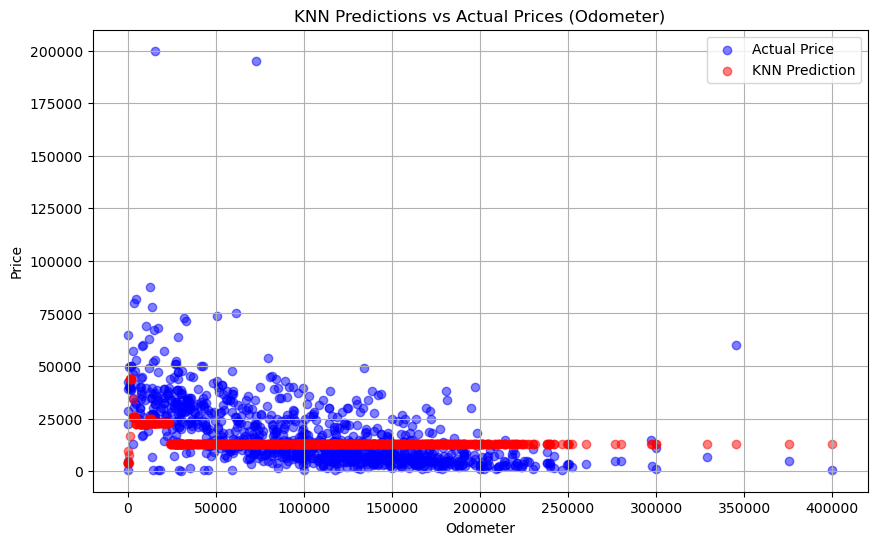

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# For visualization, we'll use a subset of the data to plot the relationship between odometer and price
sample_size = 1000
sample_idx = np.random.choice(len(X_test), sample_size, replace=False)
X_sample = X_test.iloc[sample_idx]  # Use iloc to properly index the DataFrame
y_sample = y_test.iloc[sample_idx]
knn_sample_preds = knn_model.predict(X_sample)

# Plot odometer vs price with KNN predictions
plt.figure(figsize=(10, 6))
plt.scatter(X_sample['odometer'], y_sample, color='blue', alpha=0.5, label='Actual Price')
plt.scatter(X_sample['odometer'], knn_sample_preds, color='red', alpha=0.5, label='KNN Prediction')
plt.xlabel('Odometer')  # Removed "(Scaled)" since features are not scaled in this version
plt.ylabel('Price')
plt.title('KNN Predictions vs Actual Prices (Odometer)')
plt.legend()
plt.grid(True)
plt.show('knn_odometer_vs_price.png')  # Save the plot as a file
plt.close()  # Close the plot to prevent display in the notebook